In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import glob 
from numpy.linalg import eig

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from typing import List, Set, Dict, Tuple, Optional

import seaborn as sns
%matplotlib inline

In [48]:
#Get adjusting closing prices from each {sector}.csv file
#for f in glob.glob('*.csv'):
#    df = pd.concat(pd.read_csv(f, usecols=[0,5], index_col = [0]), ignore_index = True, axis = 1)

df = pd.concat([pd.read_csv(f, usecols=[0,5], index_col = [0]) for f in glob.glob('*.csv')], ignore_index = True, axis = 1)

In [49]:
df_spx = pd.read_csv("SPX/^GSPC.csv", usecols = [0,5], index_col=[0], parse_dates=True)
df_spx_ret = df_spx.pct_change().dropna()
df_spx_ret.head()

,Adj Close
Date,
1998-12-23,0.020747
1998-12-24,-0.001848
1998-12-28,-0.000636
1998-12-29,0.013317
1998-12-30,-0.007956


In [50]:
#Get sector names 
labels = [ f[0:3] for f in glob.glob('*.csv') ]

#Dictionary of Sector Symbol to Names (maybe needed):
names = ["Mat", "Enrgy", "Fins", "Indu", "Tech", "Stpl", "Util", "Health", "Disc" ]
sym_to_name = dict(zip(labels,names))

df.columns = names

In [51]:
ret = df.pct_change().dropna()
ret.head()

,Mat,Enrgy,Fins,Indu,Tech,Stpl,Util,Health,Disc
Date,,,,,,,,,
1998-12-23,0.010504,0.020820,0.014743,0.017452,0.023893,0.024174,-0.004191,0.022472,0.004294
1998-12-24,0.023014,-0.005263,0.006607,0.013193,-0.003810,-0.001727,0.018412,0.006107,0.018327
1998-12-28,-0.008709,-0.005291,-0.013123,0.005208,0.002867,-0.005767,-0.005167,-0.014563,-0.008999
1998-12-29,0.018302,0.009973,0.010638,0.014247,0.002861,0.022042,0.016615,0.022167,0.021792
1998-12-30,-0.002876,-0.015142,-0.003949,-0.004471,-0.003802,-0.006243,-0.008172,-0.008436,-0.008294


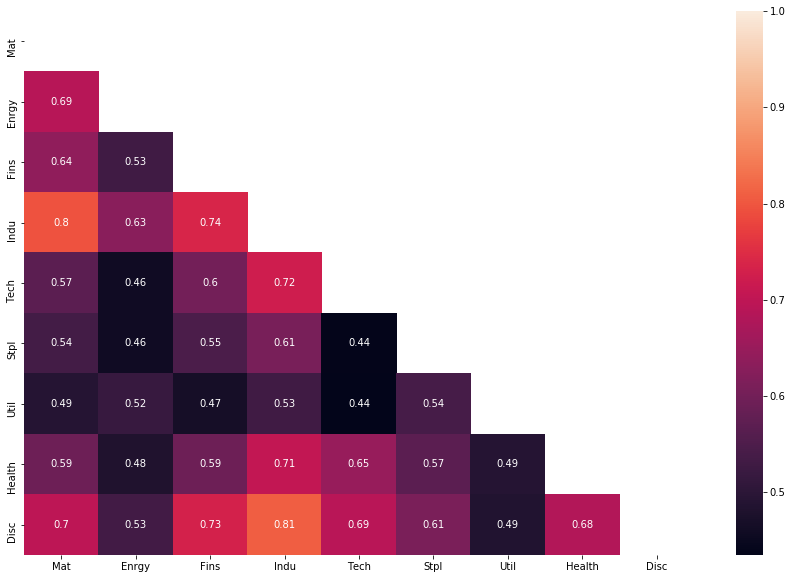

In [52]:
cor_mat = ret.corr()

plt.figure(figsize =(15,10))
mask = np.zeros_like(cor_mat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(cor_mat, mask=mask, annot=True)

In [56]:
## Function that returns Eigenvectors and Eigenvalues from returns
def get_eigen(returns: pd.DataFrame) -> Tuple [np.ndarray, np.ndarray]:
    
    eig_vals, eig_vec = eig(returns.corr())
    
    #Sort Eigenvalues (largest to smallest)
    idx = np.argsort(eig_vals)[::-1]
    eig_vals = eig_vals[idx]
    eig_vec = eig_vec[:,idx]
    return eig_vals, eig_vec

In [55]:
def eig_val_xy(eig_val: np.ndarray) -> Tuple[List, List]:
    x = list(range(eig_val.size))
    y = [val / sum (eig_val) for val in eig_val]
    return x, y

In [53]:
def plot_eig(eig_val: np.ndarray):
    x, y = eig_val_xy(eig_val)
    fig = figure()
    plt.figure(figsize =(15,10))
    plt.bar(x, y)
    plt.plot(np.cumsum(y), color = 'c')
    plt.title("Cumalative Explained Variance")
    return fig

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

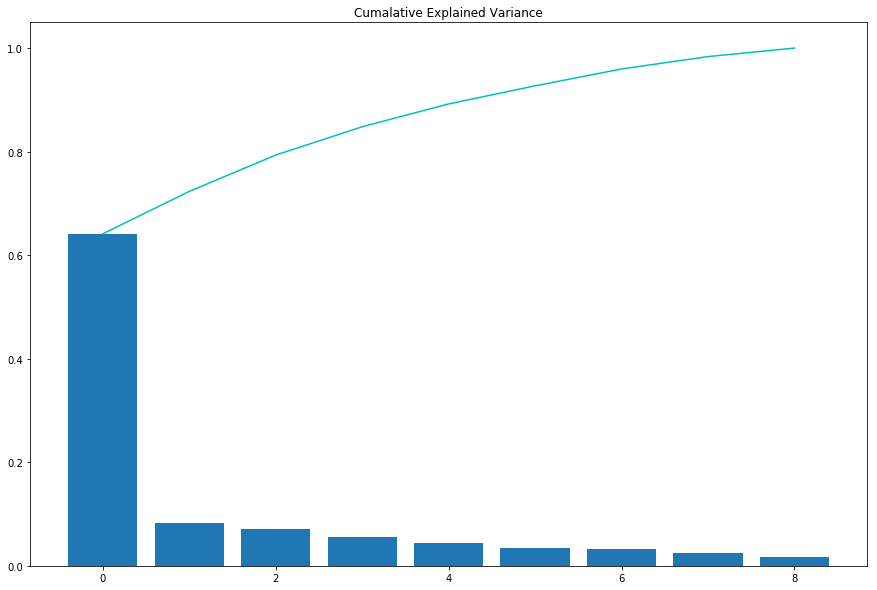

In [54]:
# Get Eigenvectors and Eigenvalues
eig_val, eig_vec = get_eigen(ret)
plot_eig(eig_val)

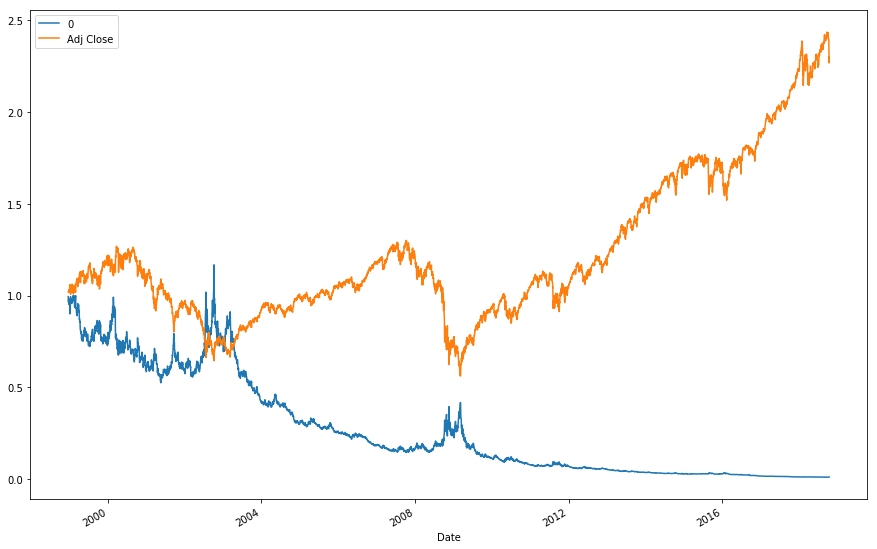

In [57]:
#plot 1st eigenvector against the market
df_comp = pd.concat([ret.dot(y1), df_spx_ret], axis = 1)
df_comp.index = df_spx_ret.index
(df_comp + 1).cumprod().plot(figsize = (15,10))

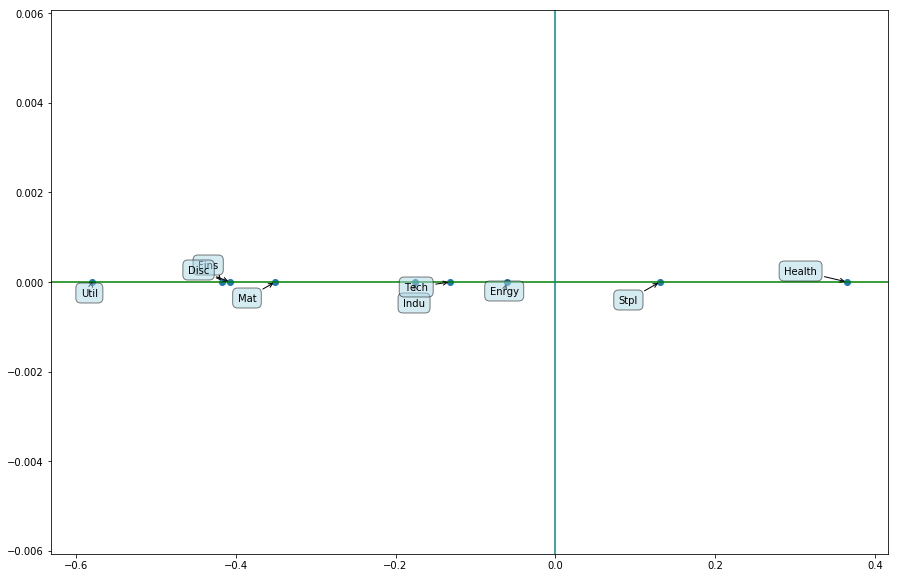

In [63]:
#project eigenvectors in 1-d
y1 = eig_vec[0,:]

plt.figure(figsize =(15,10))
plt.scatter(y1, [0]*9, marker = 'o')
plt.axhline(y = 0, color = 'g')
plt.axvline(x = 0, color = 'darkcyan')

for label, x_, y_ in zip(names, y1, [0]*9):
    plt.annotate(
        label,
        xy=(x_, y_), xytext=(np.random.randint(low =-30, high =30), np.random.randint(low =-30, high =30)),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

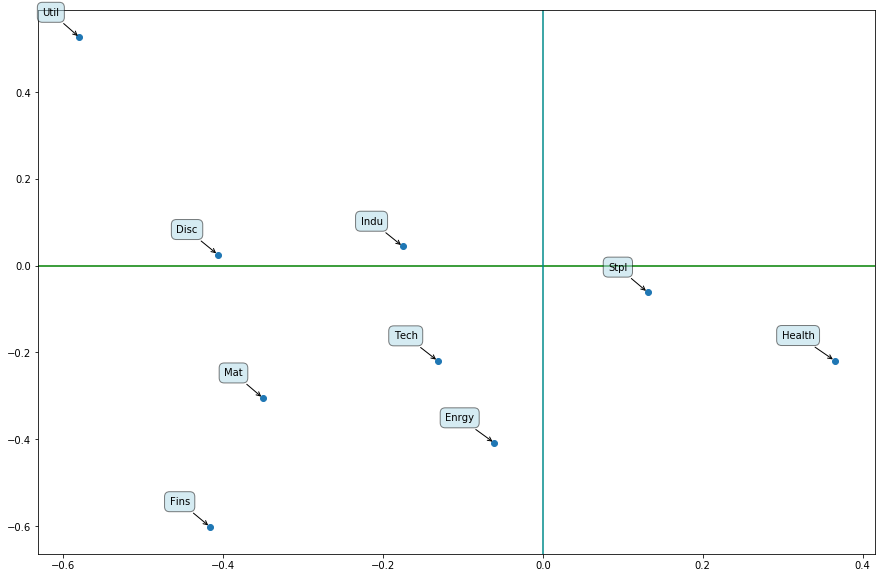

In [62]:
#project eigenvectors in 2-d
y1 = eig_vec[0,:]
y2 = eig_vec[1,:]

plt.figure(figsize =(15,10))
plt.scatter(y1, y2, marker = 'o')
plt.axhline(y = 0, color = 'g')
plt.axvline(x = 0, color = 'darkcyan')

for label, x_, y_ in zip(names, y1, y2):
    plt.annotate(
        label,
        xy=(x_, y_), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='lightblue', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

In [61]:
## Interactive covariance
def eig_vec_calc(returns, window, start = 0):
    eig_val, _ = get_eigen(returns.iloc[start:start+window,:].cov())
    x,y = eig_val_xy(eig_val)
    plt.figure(figsize =(15,10))
    plt.plot(np.cumsum(y), color = 'c')
    plt.ylim((0,1))
    plt.bar(x, y)
    plt.title('Date: {} - {}'.format(returns.index[start], returns.index[start+window]))

In [60]:

interact(eig_vec_calc, returns = fixed(ret), window = (30,300,10), start = (0,4800,30))

interactive(children=(IntSlider(value=160, description='window', max=300, min=30, step=10), IntSlider(value=0,…

<function __main__.eig_vec_calc(returns, window, start=0)>